In [2]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from pathlib import Path

# Global settings for matplotlib
fontsize = 8
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

plt.style.use("default")
plt.rcParams.update({
    #"text.usetex": False,
    #"font.family": "serif",
    #"font.serif": ["Helvetica"],
    'figure.dpi': 200,  # renders images larger for notebook
    'axes.grid': True,
    'grid.alpha': 0.3,

})
print(Path.cwd())
DATA_SOURCE = Path.cwd() / ".." / 'data' / 'input' / 'raw'
PROC_SOURCE = Path.cwd() / ".." / 'data' / 'input' / "processed"
print( DATA_SOURCE.parent)
def get_bh_integral(df):
    b, h = df.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy(), df.loc[:, [f"H_t_{k}" for k in range(1024)]].to_numpy()
    h += 100
    return df.freq * 0.5*np.abs(np.sum(b * (np.roll(h, 1, axis=1) - np.roll(h, -1, axis=1)) , axis=1))  # shoelace formula

c:\Users\tpiepe\Repositories\magnet-challenge-2023\src
c:\Users\tpiepe\Repositories\magnet-challenge-2023\src\..\data\input


In [3]:
ds = pd.read_pickle(PROC_SOURCE / "ten_materials.pkl.gz")
# full_b, full_h = ds.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy(), ds.loc[:, [f"H_t_{k}" for k in range(1024)]].to_numpy()
# print(full_b.shape)

In [4]:
# Display all available materials
materials = ds.loc[:, ["material"]]["material"].unique()
print(f"Materials: {materials}")

# Display all available temperatures
temperatures = ds.loc[:, ["temp"]]["temp"].unique()
print(f"Temperatures: {temperatures}")

Materials: ['3C90' '3C94' '3E6' '3F4' '77' '78' 'N27' 'N30' 'N49' 'N87']
Temperatures: [25 50 70 90]


In [5]:
# Choose a temperature - material pair
temperature = 25
material = 'N87'

# Display all available frequencies for the temperature - material pair
frequencies = sorted(list(ds.loc[(ds["material"] == material) & (ds["temp"] == temperature)]["freq"].unique()))
print(f"Frequencies: {frequencies}")

# downsampling with factor of ... (4 to get 1024 to 256 samples)
downsampling = 1

# filter data for the temperature - material pair
wp_ploss = ds.loc[(ds["material"] == material) & (ds["temp"] == temperature)]["ploss"].to_numpy()
wp_b_max = ds.loc[(ds["material"] == material) & (ds["temp"] == temperature)][[f"B_t_{k}" for k in range(0,1024, downsampling)]].to_numpy().max(1)
wp_b_vecs = ds.loc[(ds["material"] == material) & (ds["temp"] == temperature)][[f"B_t_{k}" for k in range(0,1024, downsampling)]].to_numpy()
wp_h_vecs = ds.loc[(ds["material"] == material) & (ds["temp"] == temperature)][[f"H_t_{k}" for k in range(0,1024, downsampling)]].to_numpy()
wp_freq = ds.loc[(ds["material"] == material) & (ds["temp"] == temperature)]["freq"].to_numpy()

# will be used later
no_samples = wp_b_vecs.shape[1]

Frequencies: [49950.0, 49960.0, 49970.0, 49980.0, 49989.9999999999, 50000.0, 50009.9999999999, 50020.0, 50040.0, 50049.9999999999, 50059.9999999999, 50069.9999999999, 50080.0, 50090.0, 50099.9999999999, 50109.9999999999, 50129.9999999999, 50140.0000000001, 50150.0000000001, 50159.9999999999, 56150.0, 56160.0, 56170.0000000001, 56180.0000000001, 56190.0, 56199.9999999999, 56209.9999999999, 56220.0000000001, 56230.0, 56240.0, 56250.0, 56260.0000000001, 56270.0000000001, 56299.9999999999, 56310.0, 56319.9999999999, 56330.0000000001, 56339.9999999999, 63010.0000000002, 63019.9999999998, 63030.0000000001, 63040.0000000002, 63060.0000000001, 63080.0000000001, 63090.0, 63100.0, 63110.0, 63120.0000000001, 63130.0000000002, 63140.0, 63150.0000000002, 63170.0, 63180.0, 63190.0, 63209.9999999999, 63220.0000000001, 63229.9999999999, 63239.9999999998, 70750.0, 70759.9999999999, 70769.9999999998, 70780.0000000001, 70790.0, 70800.0000000001, 70810.0000000001, 70819.9999999998, 70829.9999999998, 70839

1024
10152
9862
1070
258
(10152, 1024)
(10152, 1024)
(258, 1024)
(258, 1024)


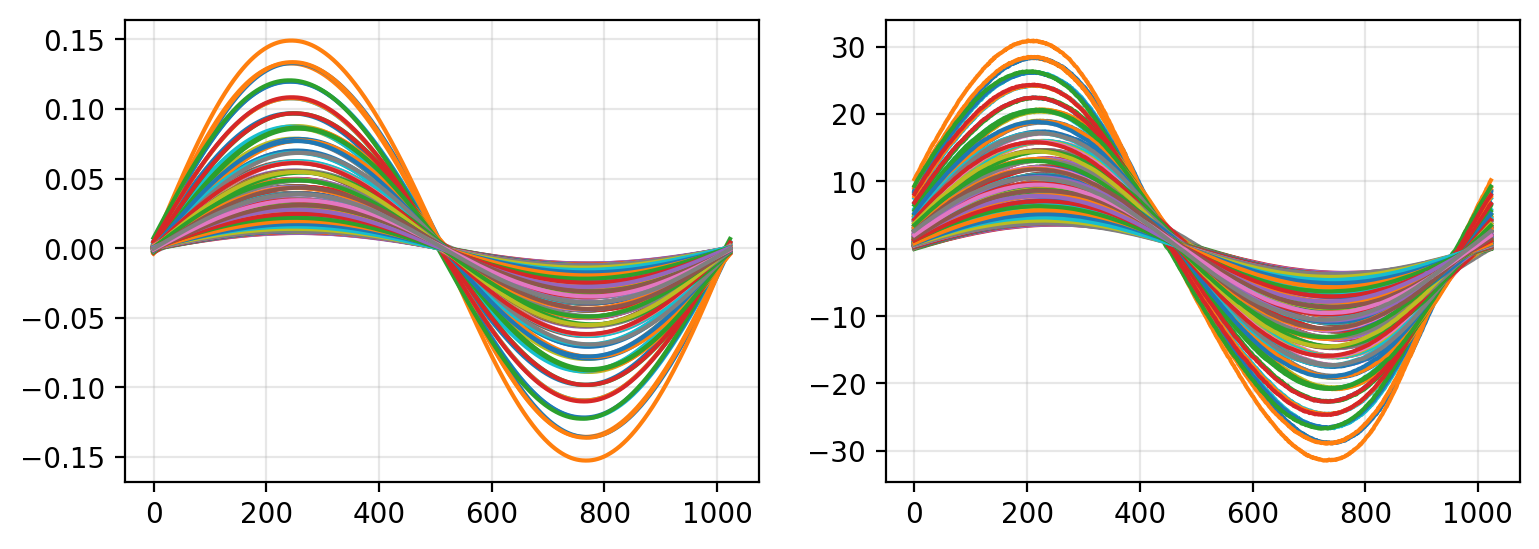

In [22]:
fig, axes = plt.subplots(1, 2, dpi=200, figsize=(9, 3), sharex=True, sharey=False)


# Additional downsampling option
print(no_samples)
samples_per_periode = no_samples 
div_factor = int(no_samples / samples_per_periode)
b = wp_b_vecs[:, ::div_factor]
h = wp_h_vecs[:, ::div_factor]

# rms = np.sqrt(np.mean(b**2, axis=1)) 
# abs = np.mean(np.abs(b), axis=1)
# form_factors = rms / mean_abs
# print(rms)
# print(mean_abs)
# print(form_factors)

def form_factor(b): 
    """kf = rms / mean(abs)"""
    return np.sqrt(np.mean(b**2, axis=1))  / np.mean(np.abs(b), axis=1)

def crest_factor(b): 
    """ks = rms / max()"""
    return np.max(np.abs(b), axis=1)  / np.sqrt(np.mean(b**2, axis=1))

# filter with form factor: only keep sines
# form factor +/- interval
interval_kf = 0.05
desired_kf = np.pi/(2*np.sqrt(2))  # ideal sine

# filter with crest factor: only keep sines
# crest factor +/- interval
interval_kc = 0.008
desired_kc = np.sqrt(2)  # ideal sine

# initialize all True
filter_bool = [True] * b.shape[0]

# statements = [[crest_factor(b) < desired_kc * (1 + interval_kc)]]
statements = [list(form_factor(b) < desired_kf * (1 + interval_kf)),
              list(form_factor(b) > desired_kf * (1 - interval_kf)),
              list(crest_factor(b) < desired_kc * (1 + interval_kc)),
              list(crest_factor(b) > desired_kc * (1 - interval_kc))]

for statement in statements:
    filter_bool = [a and zr for a, zr in zip(filter_bool, statement)]
    print(np.array(filter_bool).sum())

b_sine = b[filter_bool]
h_sine = h[filter_bool]

b_max_sine = wp_b_max[filter_bool]
freq_sine = wp_freq[filter_bool]
ploss_sine = wp_ploss[filter_bool]

print(b.shape)
print(h.shape)

print(b_sine.shape)
print(h_sine.shape)
# print(b)
# print(h)
axes[0].plot(b_sine.T)
axes[1].plot(h_sine.T)

plt.show()

[0.02488473 0.02822156 0.0317189  0.02497403 0.02782413 0.02060091
 0.02217757 0.02496052 0.01811794 0.01976392 0.02210535 0.02504413
 0.02805206 0.01792113 0.01963409 0.02229682 0.02492534 0.01579594
 0.01745081 0.019688   0.02220511 0.03122587 0.01577883 0.01741563
 0.01958733 0.02213998 0.02490352 0.02758864 0.03111905 0.03470639
 0.0391318  0.13279371 0.01410483 0.01564523 0.01751217 0.01970006
 0.02224651 0.02472029 0.02768314 0.03118845 0.03486861 0.03942749
 0.04427834 0.04964537 0.05573165 0.06230001 0.06892296 0.07778258
 0.08645561 0.11981199 0.1329894  0.1491796  0.01407222 0.01553682
 0.01757934 0.01981316 0.02198894 0.02473625 0.02772237 0.03124015
 0.03501176 0.03951858 0.04445805 0.04978085 0.05560924 0.06149364
 0.06970706 0.07729552 0.08775253 0.10771829 0.11964232 0.1336498
 0.01242864 0.01397417 0.01566695 0.01761273 0.01968774 0.02198201
 0.02484244 0.02775677 0.03126683 0.03511631 0.03965496 0.04437877
 0.04960357 0.05524339 0.06196058 0.06908074 0.07867708 0.08735

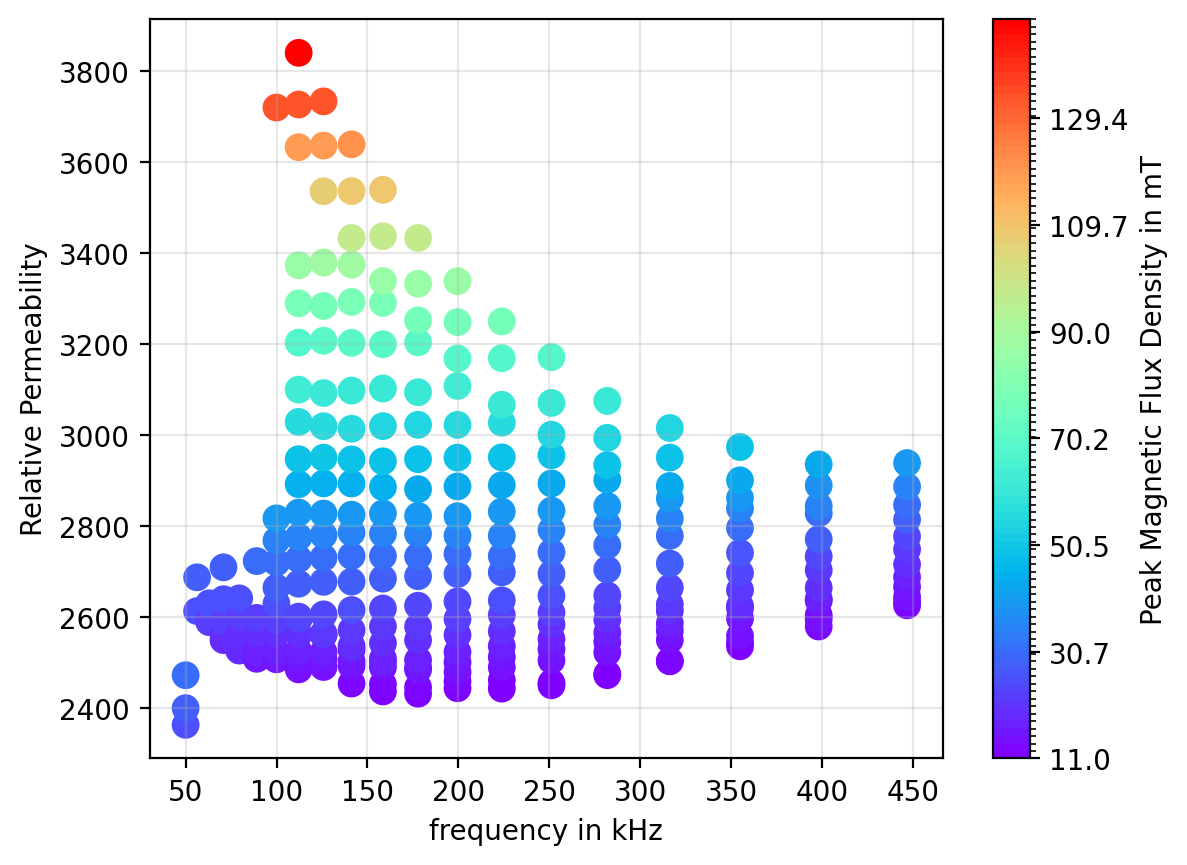

In [7]:
from scipy import constants
import matplotlib.cm as cm

b_min = 0.00
b_lim = 0.20

f_sine_lim = freq_sine[np.max(b_sine, axis=1)<b_lim]
h_sine_lim = h_sine[np.max(b_sine, axis=1)<b_lim]
ploss_sine_lim = ploss_sine[np.max(b_sine, axis=1)<b_lim]
b_sine_lim = b_sine[np.max(b_sine, axis=1)<b_lim]


f_sine_lim = f_sine_lim[np.max(b_sine_lim, axis=1)>b_min]
h_sine_lim = h_sine_lim[np.max(b_sine_lim, axis=1)>b_min]
ploss_sine_lim = ploss_sine_lim[np.max(b_sine_lim, axis=1)>b_min]
b_sine_lim = b_sine_lim[np.max(b_sine_lim, axis=1)>b_min]

mu_sine_lim = np.max(b_sine_lim, axis=1) / np.max(h_sine_lim, axis=1) / constants.mu_0

print(np.max(b_sine_lim, axis=1))

color_lim = float(np.max(np.max(b_sine_lim, axis=1)))
print(color_lim)


x = f_sine_lim / 1000
y = mu_sine_lim
z = np.max(b_sine_lim, axis=1) * 1000
cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(np.min(np.max(b_sine_lim, axis=1))*1000, np.max(b_sine_lim)*1000, (np.max(b_sine_lim)-np.min(np.max(b_sine_lim, axis=1)))*1000/100), cmap.N)
plt.scatter(x,y,c=z,cmap=cmap,norm=norm,s=100,edgecolor='none')
plt.colorbar(ticks=np.linspace(np.min(np.max(b_sine_lim, axis=1))*1000, np.max(b_sine_lim)*1000, 8), label="Peak Magnetic Flux Density in mT")
plt.xlabel("frequency in kHz")
plt.ylabel("Relative Permeability")
plt.show()


# plt.plot(f_sine_lim, mu, "x")
# plt.show()

[50020.0, 56319.9999999999, 63019.9999999998, 70829.9999999998, 70839.9999999998, 79460.0000000002, 79469.9999999999, 89080.0, 89089.9999999998, 99950.0, 112160.0, 112170.0, 125850.0, 125860.0, 141250.0, 141260.0, 141270.0, 158500.0, 158510.0, 177820.0, 199500.0, 199510.0, 223850.0, 223860.0, 251170.0, 281850.0, 281860.0, 316230.0, 354820.000000001, 398100.0, 446679.999999999, 446689.999999999]
[50020.0, 56319.9999999999, 63019.9999999998, 70829.9999999998, 70839.9999999998, 79460.0000000002, 79469.9999999999, 89080.0, 89089.9999999998, 99950.0, 112160.0, 112170.0, 125850.0, 125860.0, 141250.0, 141260.0, 141270.0, 158500.0, 158510.0, 177820.0, 199500.0, 199510.0, 223850.0, 223860.0, 251170.0, 281850.0, 281860.0, 316230.0, 354820.000000001, 398100.0, 446679.999999999, 446689.999999999]
[50020.0, 56319.9999999999, 63019.9999999998, 70834.9999999998, 79465.00000000006, 89084.9999999999, 99950.0, 112165.0, 125855.0, 141260.0, 158505.0, 177820.0, 199505.0, 223855.0, 251170.0, 281855.0, 3162

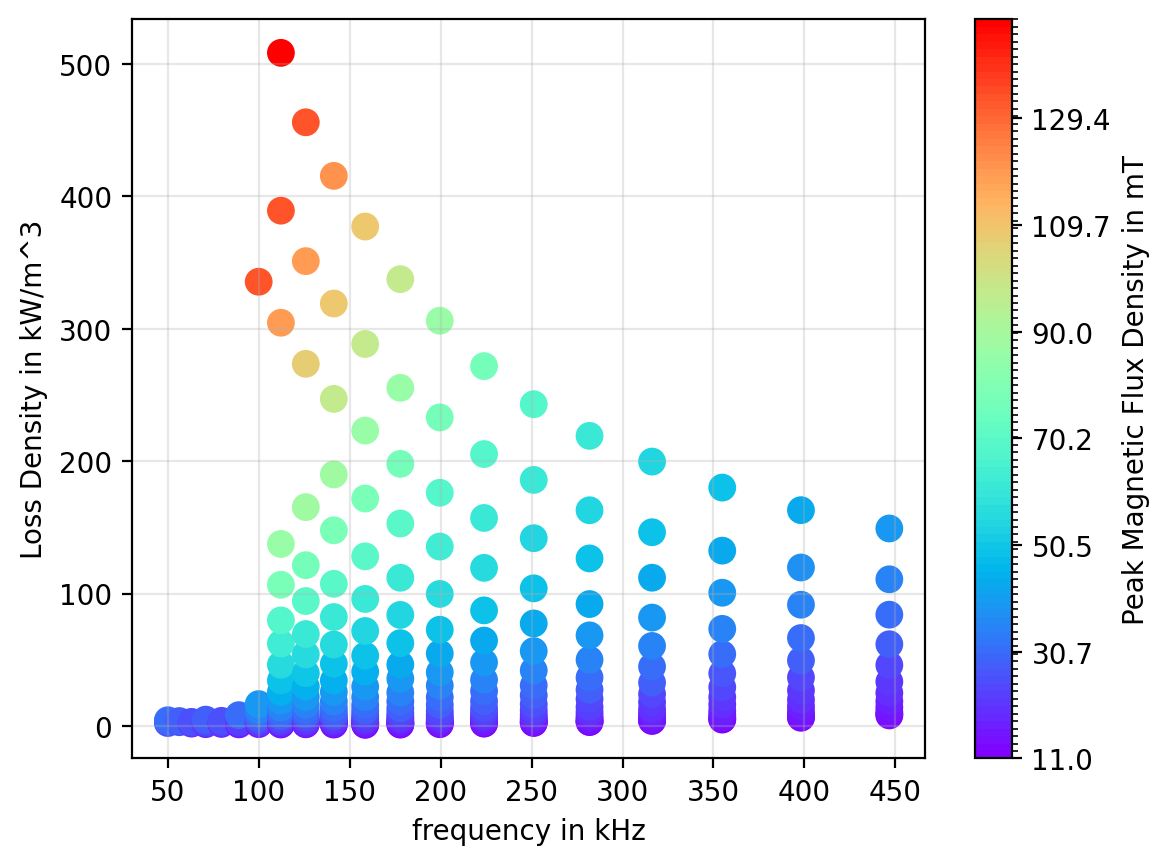

In [25]:
def cluster_measurements(x_list_input, cluster_interval=5000):
    x_list = list(x_list_input)  # copy by value not reference
    sorted_x_set = sorted(set(x_list))
    
    i = 0
    while i < len(sorted_x_set):
        j = 0
        cluster = []
        while i+j < len(sorted_x_set) and sorted_x_set[i+j] < sorted_x_set[i]+cluster_interval:
            cluster.append(sorted_x_set[i+j])
            j += 1
        mean_cluster = np.mean(cluster)
        for k in range(0, j):
            x_list[:] = [x if x != sorted_x_set[i+k] else mean_cluster for x in x_list]
        i += j
    return x_list
               
print(sorted(set(f_sine_lim)))
print(sorted(set(f_sine_lim)))
print(sorted(set(cluster_measurements(f_sine_lim))))

f_sine_lim_clustered = cluster_measurements(f_sine_lim)

# plottinh
color_lim = float(np.max(np.max(b_sine_lim, axis=1)))
print(color_lim)


x = np.array(f_sine_lim_clustered) / 1000
y = np.array(ploss_sine_lim) / 1000
z = np.max(b_sine_lim, axis=1) * 1000
cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(np.min(np.max(b_sine_lim, axis=1))*1000, np.max(b_sine_lim)*1000, (np.max(b_sine_lim)-np.min(np.max(b_sine_lim, axis=1)))*1000/100), cmap.N)
plt.scatter(x,y,c=z,cmap=cmap,norm=norm,s=100,edgecolor='none')
plt.colorbar(ticks=np.linspace(np.min(np.max(b_sine_lim, axis=1))*1000, np.max(b_sine_lim)*1000, 8), label="Peak Magnetic Flux Density in mT")
plt.xlabel("frequency in kHz")
plt.ylabel("Loss Density in kW/m^3")
plt.show()


# plt.plot(f_sine_lim, mu, "x")
# plt.show()

     frequency         b     mu_r_abs  mu_phi_deg          ploss
0      50020.0  0.024885  2362.614937    4.064708    2323.266439
1      50020.0  0.028222  2399.361236    4.514323    3267.161887
2      50020.0  0.031719  2471.724995    4.990145    4427.524958
3      56320.0  0.024974  2612.776499    5.003072    2931.161116
4      56320.0  0.027824  2686.955926    5.423751    3834.543648
..         ...       ...          ...         ...            ...
253   446685.0  0.024712  2776.829829   10.810134   46061.804533
254   446685.0  0.027702  2813.840679   11.714929   61838.482827
255   446685.0  0.030952  2846.136942   12.937880   84162.558337
256   446685.0  0.034500  2886.375847   13.931848  110874.816777
257   446685.0  0.038775  2938.217429   15.141727  149261.748322

[258 rows x 5 columns]
[50020.0, 56319.9999999999, 63019.9999999998, 70834.9999999998, 79465.00000000006, 89084.9999999999, 99950.0, 112165.0, 125855.0, 141260.0, 158505.0, 177820.0, 199505.0, 223855.0, 251170.0, 281855

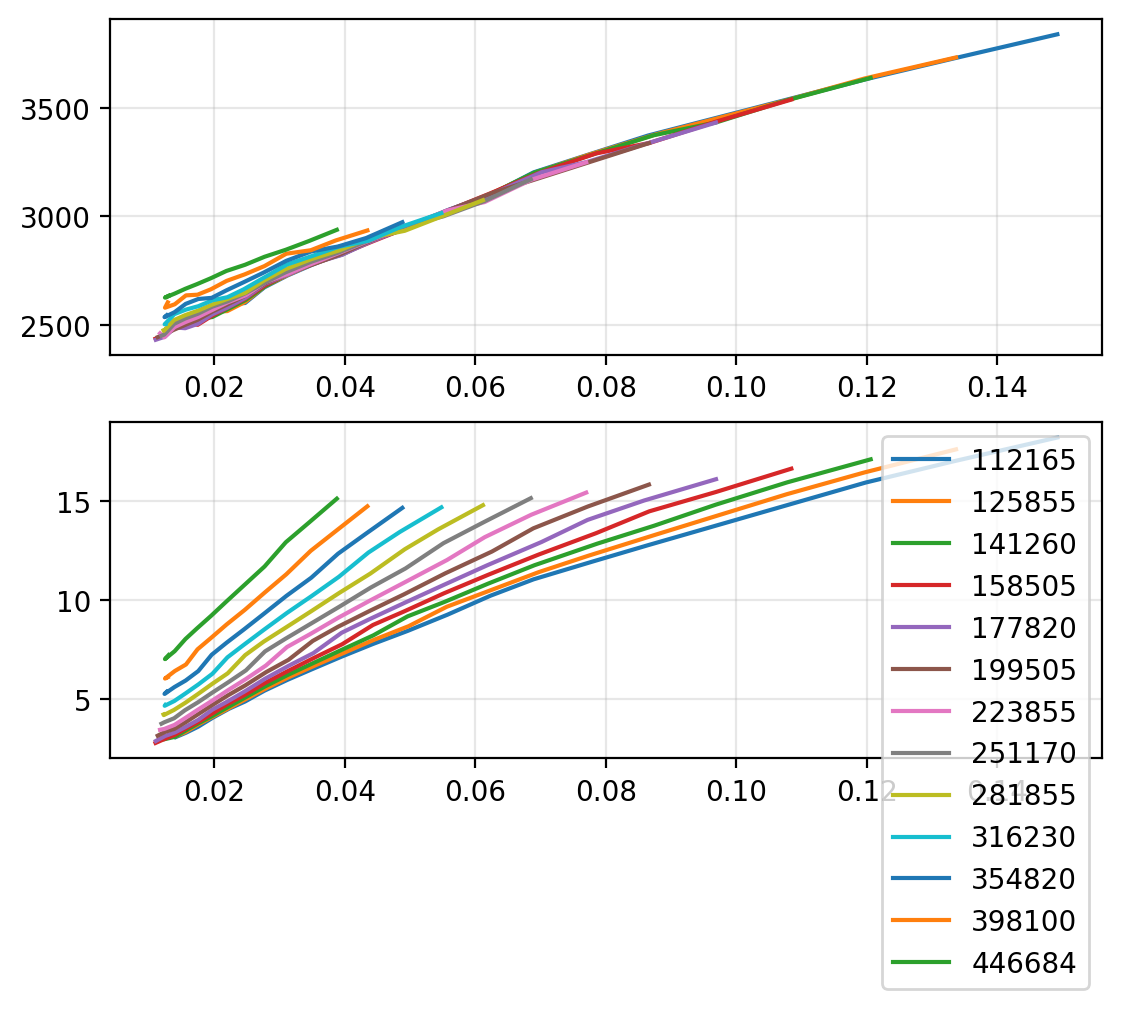

In [9]:
from scipy import constants
def mu_phi_deg__from_mu_r_and_p_hyst(frequency, b_peak, mu_r, p_hyst):
    """

    :param mu_phi_deg:
    :param frequency: frequency
    :param b_peak: peak flux density
    :param p_hyst: hysteresis losses
    :return:
    """
    b_peak = np.array(b_peak)
    return np.rad2deg(np.arcsin(p_hyst*mu_r*constants.mu_0 / (np.pi*frequency*b_peak**2)))


ds_sine = pd.DataFrame(
    {'frequency': f_sine_lim_clustered,
     'b': np.max(b_sine_lim, axis=1),
     'mu_r_abs': mu_sine_lim,
     'mu_phi_deg': mu_phi_deg__from_mu_r_and_p_hyst(np.array(f_sine_lim_clustered), np.max(b_sine_lim, axis=1), np.array(mu_sine_lim), np.array(ploss_sine_lim)),
     'ploss': ploss_sine_lim
    })


# save in material testbench
mtb_path = "N:/groups/lea/data/Studenten/30_Projekte/magnetics_testbench/MagNet/N87.csv"
ds_sine.to_csv(path_or_buf=mtb_path)

print(ds_sine)
f_sine_lim_clustered_set = sorted(set(f_sine_lim_clustered))
print(f_sine_lim_clustered_set)

fig, ax = plt.subplots(2)
for frequency in f_sine_lim_clustered_set:
    if len(ds_sine[ds_sine["frequency"]==frequency]["b"]) > 10:
        ax[0].plot(ds_sine[ds_sine["frequency"]==frequency]["b"], ds_sine[ds_sine["frequency"]==frequency]["mu_r_abs"], label=f"{int(frequency)}") 
        ax[1].plot(ds_sine[ds_sine["frequency"]==frequency]["b"], ds_sine[ds_sine["frequency"]==frequency]["mu_phi_deg"], label=f"{int(frequency)}") 

plt.legend()
plt.show()

In [11]:
def steinmetz(f, b, alpha, beta, k):
    return k*f**alpha*b**beta

def estimated_loss(alpha, beta, k, f_vec, b_vec):
    return steinmetz(f_vec, b_vec, alpha, beta, k)

def normalized_error(alpha, beta, k, f_vec, b_vec, p_loss_reference):
    return np.mean(abs((estimated_loss(alpha, beta, k, f_vec, b_vec) - p_loss_reference) / p_loss_reference))

In [12]:
def loss_over_b_and_f_3D(f_ax, b_ax, true_loss, p_estimated, log_plot = False):
    fig = plt.figure(figsize=(6, 8))
    ax = fig.add_subplot(projection='3d')

    
    z_label = "losses 10^x in W/m³" if log_plot else "losses in W/m³"

    # Estimation plot
    p1 = np.log10(p_estimated) if log_plot else p_estimated
    sc = ax.scatter(b_ax, f_ax, p1, color='red', label="estimated loss")
    z1=np.ones(shape=b_ax.shape)*min(p1)
    # lines
    for i,j,k,h in zip(b_ax, f_ax, p1, z1):
        ax.plot([i,i],[j,j],[k,h], color='grey')

    # Measurement plot
    p2 = np.log10(true_loss) if log_plot else true_loss
    sc = ax.scatter(b_ax, f_ax, p2, color='blue', label="measured loss")
    z2=np.ones(shape=b_ax.shape)*min(p2)
    # lines
    for i,j,k,h in zip(b_ax, f_ax, p2, z2):
        ax.plot([i,i],[j,j],[k,h], color='grey')


    sc = ax.scatter(b_ax, f_ax, np.log10(true_loss))
    ax.set_zlabel(z_label, fontsize=fontsize, rotation = 0)

    # sc = ax.scatter(b_max, freq, p_estimated)
    # sc = ax.scatter(b_max, freq, ploss)
    # plt.ylabel("frequency in Hz", fontsize=fontsize)
    plt.xlabel("Bpeak in T", fontsize=fontsize)
    plt.ylabel("frequency in Hz", fontsize=fontsize)
    plt.legend()


    plt.show()

In [13]:
import optuna

def objective(trial):
    aa = trial.suggest_float('aa', 1, 2)
    bb = trial.suggest_float('bb', 2.5, 4)
    kk = trial.suggest_float('kk', 0.1, 100)
    return normalized_error(aa, bb, kk, freq_sine, b_max_sine, ploss_sine)

study = optuna.create_study()
study.optimize(objective, n_trials=500)

study.best_params  # E.g. {'x': 2.002108042}

c:\Users\tpiepe\Repositories\magnet-challenge-2023\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-07-21 10:31:51,633] A new study created in memory with name: no-name-90134c2f-b5a5-4852-a99f-70667a90b4a5
[I 2023-07-21 10:31:51,640] Trial 0 finished with value: 29.8195148932168 and parameters: {'aa': 1.9779462497796207, 'bb': 3.9101246927915367, 'kk': 13.843393691766947}. Best is trial 0 with value: 29.8195148932168.
[I 2023-07-21 10:31:51,642] Trial 1 finished with value: 0.9905315428976967 and parameters: {'aa': 1.0220783827019222, 'bb': 3.4210203494475726, 'kk': 97.44583820332585}. Best is trial 1 with value: 0.9905315428976967.
[I 2023-07-21 10:31:51,643] Trial 2 finished with value: 1.4035973190344 and parameters: {'aa': 1.6415417481558254, 'bb': 3.680899935231439, 'kk': 30.741079882706114}. Best

{'aa': 1.189390565301061, 'bb': 2.6070022158811095, 'kk': 87.81225138390732}

0.10426275431713325


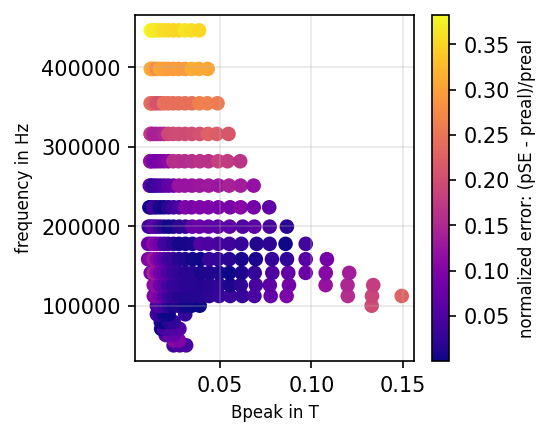

In [14]:
# in sample error (training set = test set)
error_norm = (estimated_loss(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], freq_sine, b_max_sine) - ploss_sine) / ploss_sine

print(normalized_error(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], freq_sine, b_max_sine, ploss_sine))
# 1D error plots
#plt.scatter(b_max, error_norm)
#plt.scatter(freq, error_norm)

# 2D error plots
plt.figure(dpi=150, figsize=(3,3))
cm = matplotlib.colormaps['plasma']
xy = range(20)
sc = plt.scatter(b_max_sine, freq_sine, c=abs(error_norm), vmin=None, vmax=None, s=None, cmap=cm)
cbar = plt.colorbar(sc, )
cbar.set_label('normalized error: (pSE - preal)/preal', fontsize=fontsize)
plt.xlabel("Bpeak in T", fontsize=fontsize)
plt.ylabel("frequency in Hz", fontsize=fontsize)

plt.show()

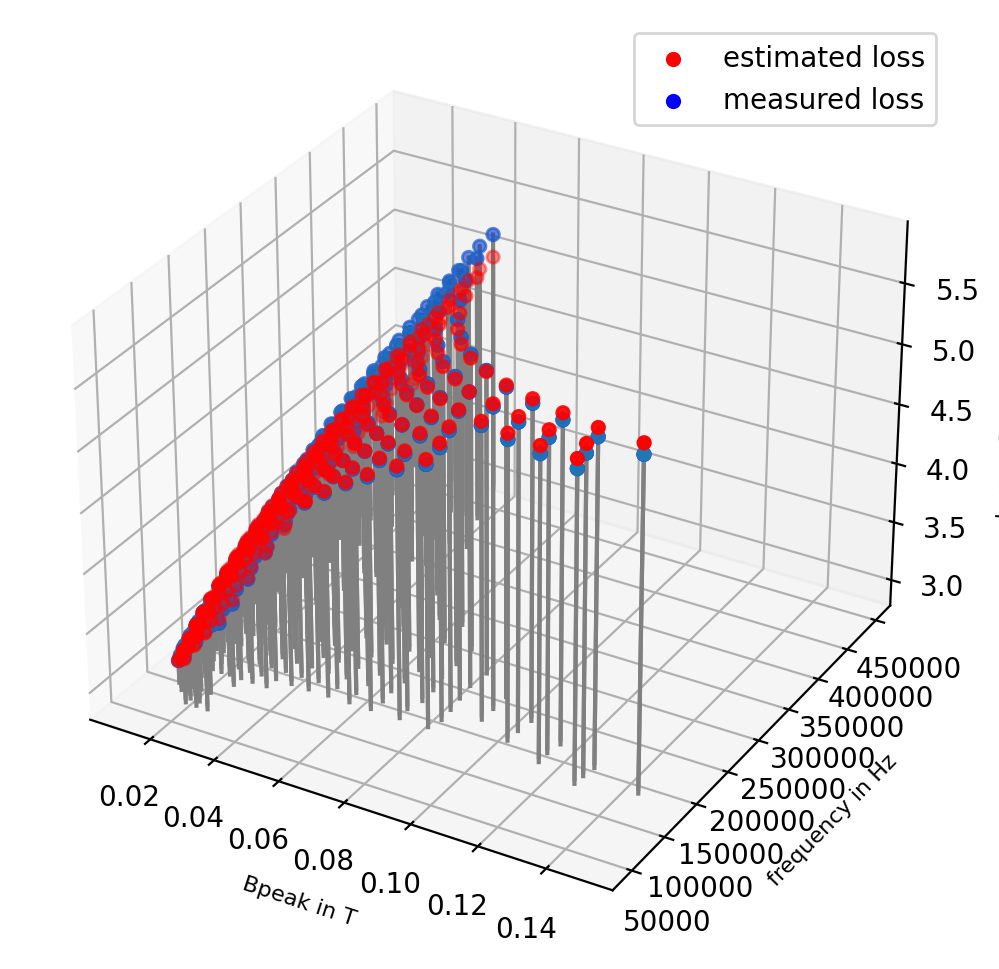

In [15]:
p_estimated = estimated_loss(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], freq_sine, b_max_sine)
true_loss = ploss_sine
b_ax = b_max_sine
f_ax = freq_sine

loss_over_b_and_f_3D(f_ax, b_ax, true_loss, p_estimated, log_plot = True)

0.2546501819775665


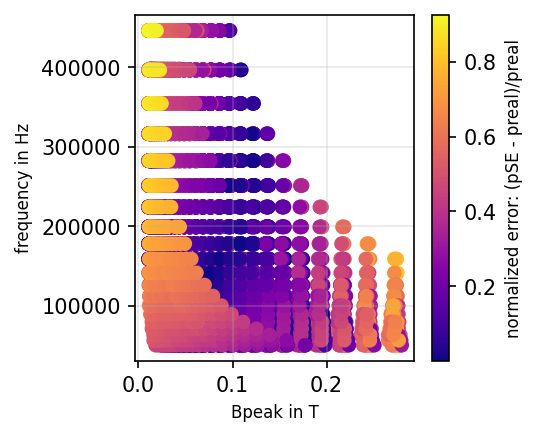

In [16]:
# in sample error (training set = test set)
wp_error_norm = (estimated_loss(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], wp_freq, wp_b_max) - wp_ploss) / wp_ploss

print(normalized_error(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], wp_freq, wp_b_max, wp_ploss))


# 1D error plots
#plt.scatter(b_max, error_norm)
#plt.scatter(freq, error_norm)

# 2D error plots
plt.figure(dpi=150, figsize=(3,3))
cm = matplotlib.colormaps['plasma']
xy = range(20)
sc = plt.scatter(wp_b_max, wp_freq, c=abs(wp_error_norm), vmin=None, vmax=None, s=None, cmap=cm)
cbar = plt.colorbar(sc, )
cbar.set_label('normalized error: (pSE - preal)/preal', fontsize=fontsize)
plt.xlabel("Bpeak in T", fontsize=fontsize)
plt.ylabel("frequency in Hz", fontsize=fontsize)

plt.show()

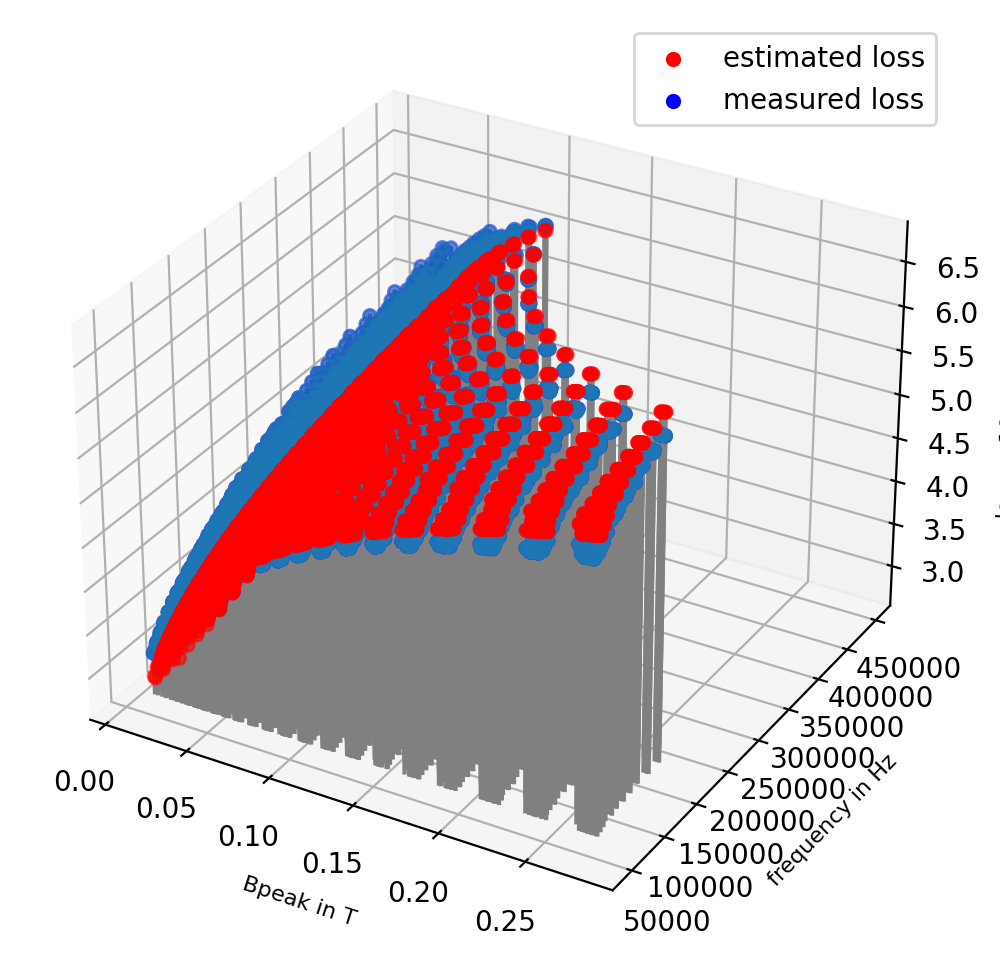

In [17]:
p_estimated = estimated_loss(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], wp_freq, wp_b_max)
true_loss = wp_ploss
b_ax = wp_b_max
f_ax = wp_freq

loss_over_b_and_f_3D(f_ax, b_ax, true_loss, p_estimated, log_plot = True)

In [18]:
def iGSE2(alpha, beta, k, b_vec, f, samples):
    theta = np.linspace(0, 2*np.pi, 20)
    k_i = k / ((2*np.pi)**(alpha-1) * np.trapz(abs(np.cos(theta))**alpha * 2**(beta-alpha)))
    print(b_vec.shape)
    print(b_vec.shape)
    dB_dt = np.gradient(b_vec, 1/f/samples, axis=1)
    print(dB_dt)
    # print(f.shape)

    # k_i = k
    # dB_dt = np.gradient(b_vec, 1)
    # print(dB_dt[0].shape)
    # print(np.abs(dB_dt[0]).shape)
    # print((np.max(b, axis=1)-np.min(b, axis=1)).shape)
    integrant = k_i * np.matmul(np.abs(dB_dt[0]).T**alpha, ((np.max(b_vec, axis=1)-np.min(b_vec, axis=1))**(beta-alpha)))
    return f * np.trapz(integrant)

def iGSE(alpha, beta, k, b_vec, fs, samples):
    theta = np.linspace(0, 2*np.pi, 100)
    k_i = k / ((2*np.pi)**(alpha-1) * np.trapz(abs(np.cos(theta))**alpha * 2**(beta-alpha), dx=2*np.pi/100))
    
    loss = []
    for i, f_i in enumerate(fs):
        dt = 1/f_i/samples
        b_i = b_vec[i]
        # print(b_i.shape)
        dB_dt = np.gradient(b_i, dt, axis=0)
        # print(dB_dt.shape)    
        integrant = k_i * np.abs(dB_dt)**alpha * (np.max(b_i, axis=0)-np.min(b_i, axis=0))**(beta-alpha)
        
        loss.append(f_i * np.trapz(integrant, axis=0, dx=dt))

    return loss

def estimated_loss_iGSE(alpha, beta, k, f_vec, b_vec_vec, samples):
    return iGSE(alpha, beta, k, b_vec_vec, f_vec, samples)

def normalized_error_iGSE(alpha, beta, k, f_vec, b_vec_vec, p_loss_reference, samples):
    return np.mean(abs((estimated_loss_iGSE(alpha, beta, k, f_vec, b_vec_vec, samples) - p_loss_reference) / p_loss_reference))

0.2458378339461862


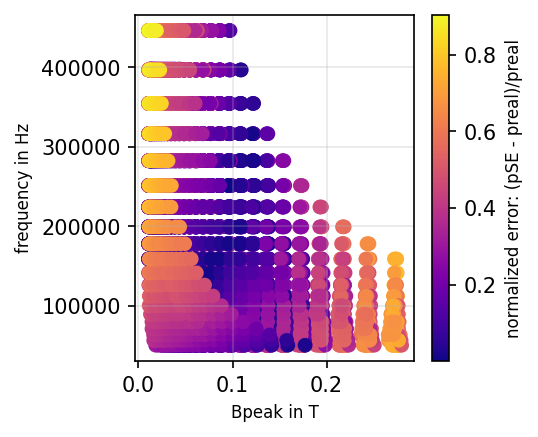

In [19]:
# in sample error (training set = test set)
error_norm = (estimated_loss_iGSE(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], wp_freq, wp_b_vecs, no_samples) - wp_ploss) / wp_ploss

print(normalized_error_iGSE(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], wp_freq, wp_b_vecs, wp_ploss, no_samples))

# 1D error plots
#plt.scatter(b_max, error_norm)
#plt.scatter(freq, error_norm)

# 2D error plots
plt.figure(dpi=150, figsize=(3,3))
cm = matplotlib.colormaps['plasma']
xy = range(20)
sc = plt.scatter(wp_b_max, wp_freq, c=np.abs(error_norm), vmin=None, vmax=None, s=None, cmap=cm)
cbar = plt.colorbar(sc, )
cbar.set_label('normalized error: (pSE - preal)/preal', fontsize=fontsize)
plt.xlabel("Bpeak in T", fontsize=fontsize)
plt.ylabel("frequency in Hz", fontsize=fontsize)

plt.show()

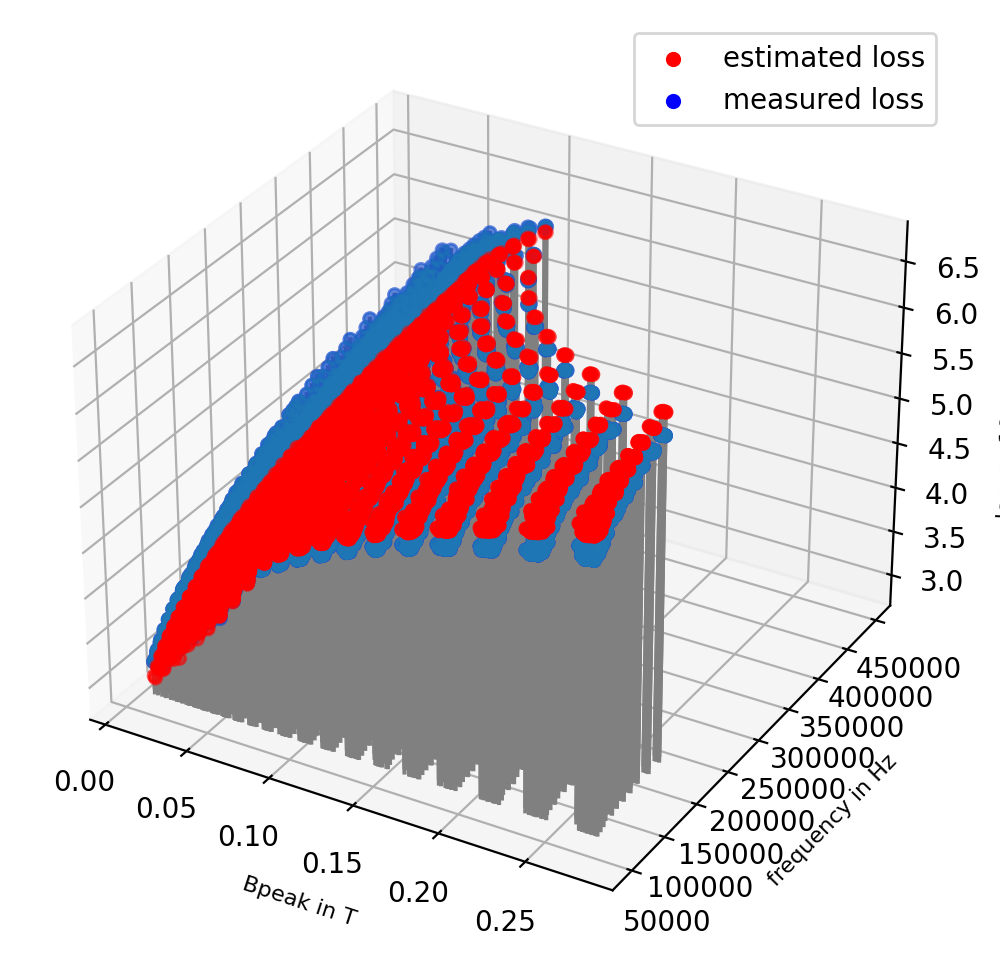

In [20]:
p_estimated = estimated_loss_iGSE(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], wp_freq, wp_b_vecs, no_samples)
true_loss = wp_ploss
b_ax = wp_b_max
f_ax = wp_freq


loss_over_b_and_f_3D(f_ax, b_ax, true_loss, p_estimated, log_plot = True)
